Full Name: Juan Pablo Grimaldi

Username: jgri0027

ID: 32980523



### 1.1.1 Create SparkSession<a class="anchor" id="1.1.1"></a>
[Back to top](#table)

Write the code to get a SparkSession. For creating the SparkSession, you need to use a SparkConf object to configure the Spark app with a proper application name, to enable the maximum partition size not exceed 10MB, and to run locally with as many working processors as local cores on your machine

In [246]:
#
# Import SparkConf class into program
from pyspark import SparkConf
from pyspark.sql import SparkSession  # Spark SQL

# the below setup will run Spark in local mode with * working processors (equal to logical cores on the machine)
master = "local[*]"

# Setup `appName` field to be displayed at Spark cluster UI page
app_name = "FIT5202 Assignment 2"
# Setup configuration parameters for Spark
spark_conf = (SparkConf()
              .setMaster(master)
              .setAppName(app_name)
              .set('spark.sql.files.maxPartitionBytes', '10mb'))

# Setup SparkSession and configure it with Melbourne timezone.

spark = (
    SparkSession.builder.config(conf=spark_conf)
    .config("spark.sql.session.timeZone", "UTC+11")
    .config("spark.driver.extraJavaOptions", "-Duser.timezone=GMT+11")
    .config("spark.executor.extraJavaOptions", "-Duser.timezone=GMT+11")
    .getOrCreate()
)
sc = spark.sparkContext
sc.setLogLevel("ERROR")

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE"> Documentation: </strong>
Explain the SparkConf object that you have created, and how do you set the enable the maximum partition (1 mark).
</div>

## UDF

In [247]:
def schema_display(df, name):
    """
    print schema of a Spark Dataframe
    df: Spark Dataframe object
    name: Given name to the object
    """
    print("---- {} ----".format(name))
    pp.pprint(df.printSchema())


def check_nulls(df, name):
    """
    Check for missing data and null values in Spark Dataframe

    """
    print("---- {} Missing/Null values ----".format(name))
    df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c)
               for c in df.columns]).show()

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE"> Documentation: </strong>
Explain each UDF (and add more if necesary)
</div>

In [248]:
# Question 1: What about Melbourne time zone?

### 1.1.2 Define schemas<a class="anchor" id="1.1.1"></a>
[Back to top](#table)

Write code to define the data schema for features, sales and stores datasets, following the data types suggested in the metadata file.

In [344]:
# setup
import pprint as pp
import matplotlib.pyplot as plt
# Import PySpark Pandas
import pyspark.pandas as ps

import pyspark.sql.functions as F
from pyspark.sql.functions import (
    col, lit, to_date, to_timestamp, isnan, when, count
)
from pyspark.sql.types import (
    BooleanType,
    FloatType,
    IntegerType,
    StringType,
    StructField,
    StructType,
    DateType
)

import warnings
warnings.filterwarnings('ignore')

In [360]:
# assign data type for each dataframe column
# features data type
features_labels = [
    ("Store", StringType()),
    ("Date", StringType()),
    ("Temperature", FloatType()),
    ("Fuel_Price", FloatType()),
    ("MarkDown1", FloatType()),
    ("MarkDown2", FloatType()),
    ("MarkDown3", FloatType()),
    ("MarkDown4", FloatType()),
    ("MarkDown5", FloatType()),
    ("CPI", FloatType()),
    ("Unemployment", FloatType()),
    ("IsHoliday", StringType()),
]
# sales data types
sales_labels = [
    ("Store", StringType()),
    ("Dept", StringType()),
    ("Date", StringType()),
    ("Weekly_Sales", FloatType()),
    ("IsHoliday", StringType()),
]
# stores data type
stores_labels = [
    ("Store", StringType()),
    ("Type", StringType()),
    ("Size", IntegerType()),
]

# features schema
features_schema = StructType(
    [StructField(x[0], x[1], True) for x in features_labels])
# sales schema
sales_schema = StructType([StructField(x[0], x[1], True)
                          for x in sales_labels])
# stores schema
stores_schema = StructType([StructField(x[0], x[1], True)
                           for x in stores_labels])

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE"> Documentation: </strong>
Explain the schema of each DataFrame you have created (e.g., 1. spark objects do you use. 2. parameters) (2 marks)
</div>

### 1.1.3 Load three DF<a class="anchor" id="1.1.1"></a>
[Back to top](#table)

Using predefined schema, write code to load the features, sales and stores csv files into separate dataframes. Print the schemas for all of the dataframes

In [361]:
# read with utf-8 encoding.

df_features = (
    spark.read.format("csv")
    .option("header", True)
    .option("encoding", "UTF-8")
    .load("data/Features.csv", schema=features_schema)
)

df_sales = (
    spark.read.format("csv")
    .option("header", True)
    .option("encoding", "UTF-8")
    .load("data/sales.csv", schema=sales_schema)
)

df_stores = (
    spark.read.format("csv")
    .option("header", True)
    .option("encoding", "UTF-8")
    .load("data/stores.csv", schema=stores_schema)
)

In [357]:
# print schema
schema_display(df_features, "Features DF Schema")
schema_display(df_sales, "Sales DF Schema")
schema_display(df_stores, "Stores DF Schema")

---- Features DF Schema ----
root
 |-- Store: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Temperature: float (nullable = true)
 |-- Fuel_Price: float (nullable = true)
 |-- MarkDown1: float (nullable = true)
 |-- MarkDown2: float (nullable = true)
 |-- MarkDown3: float (nullable = true)
 |-- MarkDown4: float (nullable = true)
 |-- MarkDown5: float (nullable = true)
 |-- CPI: float (nullable = true)
 |-- Unemployment: float (nullable = true)
 |-- IsHoliday: string (nullable = true)

None
---- Sales DF Schema ----
root
 |-- Store: string (nullable = true)
 |-- Dept: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Weekly_Sales: float (nullable = true)
 |-- IsHoliday: string (nullable = true)

None
---- Stores DF Schema ----
root
 |-- Store: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Size: integer (nullable = true)

None


<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE"> Documentation: </strong>
Explain the spark object you used to load the data into one of a dataframe (e.g., 1. spark objects do you use. 2. parameters) (1 mark)
</div>

### 1.2.1 Exploring the data<a class="anchor" id="1.1.1"></a>
[Back to top](#table)

Write code to show the total ‘null’ counts for each column in all of the three dataframes.

In [362]:
check_nulls(df_features, "Features")
check_nulls(df_sales, "Sales")
check_nulls(df_stores, "Stores")

---- Features Missing/Null values ----
+-----+----+-----------+----------+---------+---------+---------+---------+---------+---+------------+---------+
|Store|Date|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|CPI|Unemployment|IsHoliday|
+-----+----+-----------+----------+---------+---------+---------+---------+---------+---+------------+---------+
|    0|   0|          0|         0|     4158|     5269|     4577|     4726|     4140|585|         585|        0|
+-----+----+-----------+----------+---------+---------+---------+---------+---------+---+------------+---------+

---- Sales Missing/Null values ----
+-----+----+----+------------+---------+
|Store|Dept|Date|Weekly_Sales|IsHoliday|
+-----+----+----+------------+---------+
|    0|   0|   0|           0|        0|
+-----+----+----+------------+---------+

---- Stores Missing/Null values ----
+-----+----+----+
|Store|Type|Size|
+-----+----+----+
|    0|   0|   0|
+-----+----+----+



In [363]:
# transform features date field to date type
df_features = df_features.withColumn("Date", to_date(col("Date"), "d/M/y"))
# transform sales date field to date type
df_sales = df_sales.withColumn("Date", to_date(col("Date"), "d/M/y"))

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE"> Documentation: </strong>
Explain the process in this task (e.g., the steps in a function you have created). Any method of a pyspark object used, the parameters, and the variables involved (1 mark)
</div>

### 1.2.2 Exploring the data<a class="anchor" id="1.1.1"></a>
[Back to top](#table)

For each features, sales and stores dataframe, write code to show the basic statistics (including count, mean, stddev, min, max, 25 percentile, 50 percentile, 75 percentile) for each numeric column. For each non-numeric feature in each dataframe, display the top-5 values and the corresponding counts, except for the columns of “Store”, “Dept" and "Date

In [364]:
# UDF
def basic_statistics(df, name):
    """
    Basic statistics for numeric and non-numeric columns in a given dataframe.
    The function splits columns into numeric and non-numeric
    """
    new_df = ps.DataFrame(df)
    num_cols = []
    nonnum_cols = []
    # split columns into numeric and non-numeric
    for each in df.dtypes:
        if each[1] == 'string' and each[0] not in ('Store', 'Dept', 'Date'):
            nonnum_cols.append(each[0])
        else:
            num_cols.append(each[0])
    # numeric column summary
    print(f"---- {name} Dataframe Numeric Statistical Summary ----\n")
    pp.pprint(new_df.describe())
    print("\n")
    # non-numeric column summary
    print(f"---- {name} Dataframe Non-Numeric Statistical Summary ----\n")
    for each in nonnum_cols:
        print(f"---- {each} Summary ----\n")
        pp.pprint(new_df[each].value_counts().sort_values(ascending=False)[:6])

In [365]:
basic_statistics(df_features, "Features")

---- Features Dataframe Numeric Statistical Summary ----

       Temperature   Fuel_Price      MarkDown1      MarkDown2      MarkDown3     MarkDown4      MarkDown5          CPI  Unemployment
count  8190.000000  8190.000000    4032.000000    2921.000000    3613.000000   3464.000000    4050.000000  7605.000000   7605.000000
mean     59.356198     3.405992    7032.371786    3384.176593    1760.100176   3292.935892    4132.216427   172.460809      7.826821
std      18.678607     0.431337    9262.747449    8793.583001   11276.462187   6792.329889   13086.690637    39.738346      1.877259
min      -7.290000     2.472000   -2781.450000    -265.760000    -179.260000      0.220000    -185.170000   126.064000      3.684000
25%      45.900000     3.041000    1577.330000      68.880000       6.600000    303.930000    1440.800000   132.364840      6.634000
50%      60.710000     3.512000    4737.510000     364.570000      36.260000   1175.760000    2725.280000   182.716840      7.806000
75%      73

In [366]:
basic_statistics(df_sales, "Sales")

---- Sales Dataframe Numeric Statistical Summary ----

        Weekly_Sales
count  421570.000000
mean    15981.258121
std     22711.183512
min     -4988.940000
25%      2079.390000
50%      7612.100000
75%     20200.750000
max    693099.400000


---- Sales Dataframe Non-Numeric Statistical Summary ----

---- IsHoliday Summary ----

FALSE    391909
TRUE      29661
Name: IsHoliday, dtype: int64


In [367]:
basic_statistics(df_stores, "Sales")

---- Sales Dataframe Numeric Statistical Summary ----

                Size
count      45.000000
mean   130287.600000
std     63825.271991
min     34875.000000
25%     70713.000000
50%    126512.000000
75%    202307.000000
max    219622.000000


---- Sales Dataframe Non-Numeric Statistical Summary ----

---- Type Summary ----

A    22
B    17
C     6
Name: Type, dtype: int64


### 1.2.3 Exploring the data<a class="anchor" id="1.1.1"></a>
[Back to top](#table)

Write code to display a histogram to show the distribution of the weekly sales for stores with log-scale for the frequency axis. Describe what you observe from the plot

In [450]:
import matplotlib.pyplot as plt
import seaborn as sns

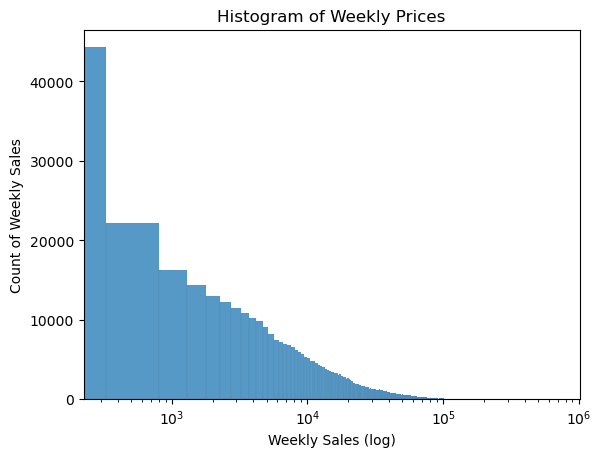

In [370]:
# create a seaborn line plot where e
df_sales_pd = df_sales.toPandas()
sns.histplot(data=df_sales_pd, x="Weekly_Sales")
plt.xscale('log')
plt.xlabel('Weekly Sales (log)')
plt.ylabel('Count of Weekly Sales')
plt.title('Histogram of Weekly Prices');

### 1.2.3 Exploring the data<a class="anchor" id="1.1.1"></a>
[Back to top](#table)

Apart from that, Draw a line-plot to show the trend of the average weekly sales of the month based on the different stores

In [391]:
df_sales.show(5)

+-----+----+----------+------------+---------+
|Store|Dept|      Date|Weekly_Sales|IsHoliday|
+-----+----+----------+------------+---------+
|    1|   1|2010-02-05|     24924.5|    FALSE|
|    1|   1|2010-02-12|    46039.49|     TRUE|
|    1|   1|2010-02-19|    41595.55|    FALSE|
|    1|   1|2010-02-26|    19403.54|    FALSE|
|    1|   1|2010-03-05|     21827.9|    FALSE|
+-----+----+----------+------------+---------+
only showing top 5 rows



In [401]:
# average weekly sales by store
# group it for performance improvement
plot = (df_sales
        .withColumn("Month", F.month(col("Date")))
        .groupby("Store", "Month")
        .agg(sum("Weekly_Sales")
             .cast('Decimal(12,2)')
            .alias("Weekly_Sales"))
        .toPandas())

In [416]:
plot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Store         540 non-null    object
 1   Month         540 non-null    int32 
 2   Weekly_Sales  540 non-null    object
dtypes: int32(1), object(2)
memory usage: 10.7+ KB


<AxesSubplot: xlabel='Month', ylabel='Weekly_Sales'>

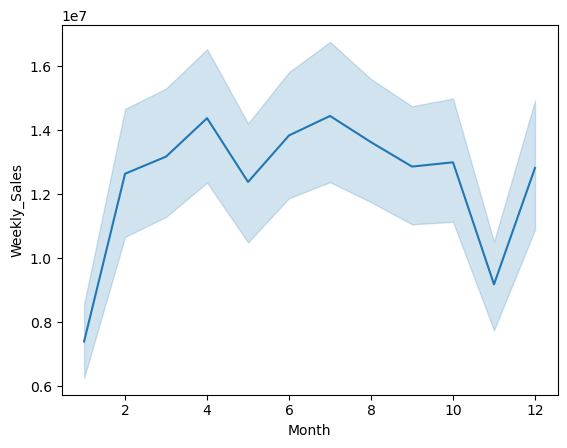

In [409]:
sns.lineplot(data=plot,y="Weekly_Sales",x="Month")

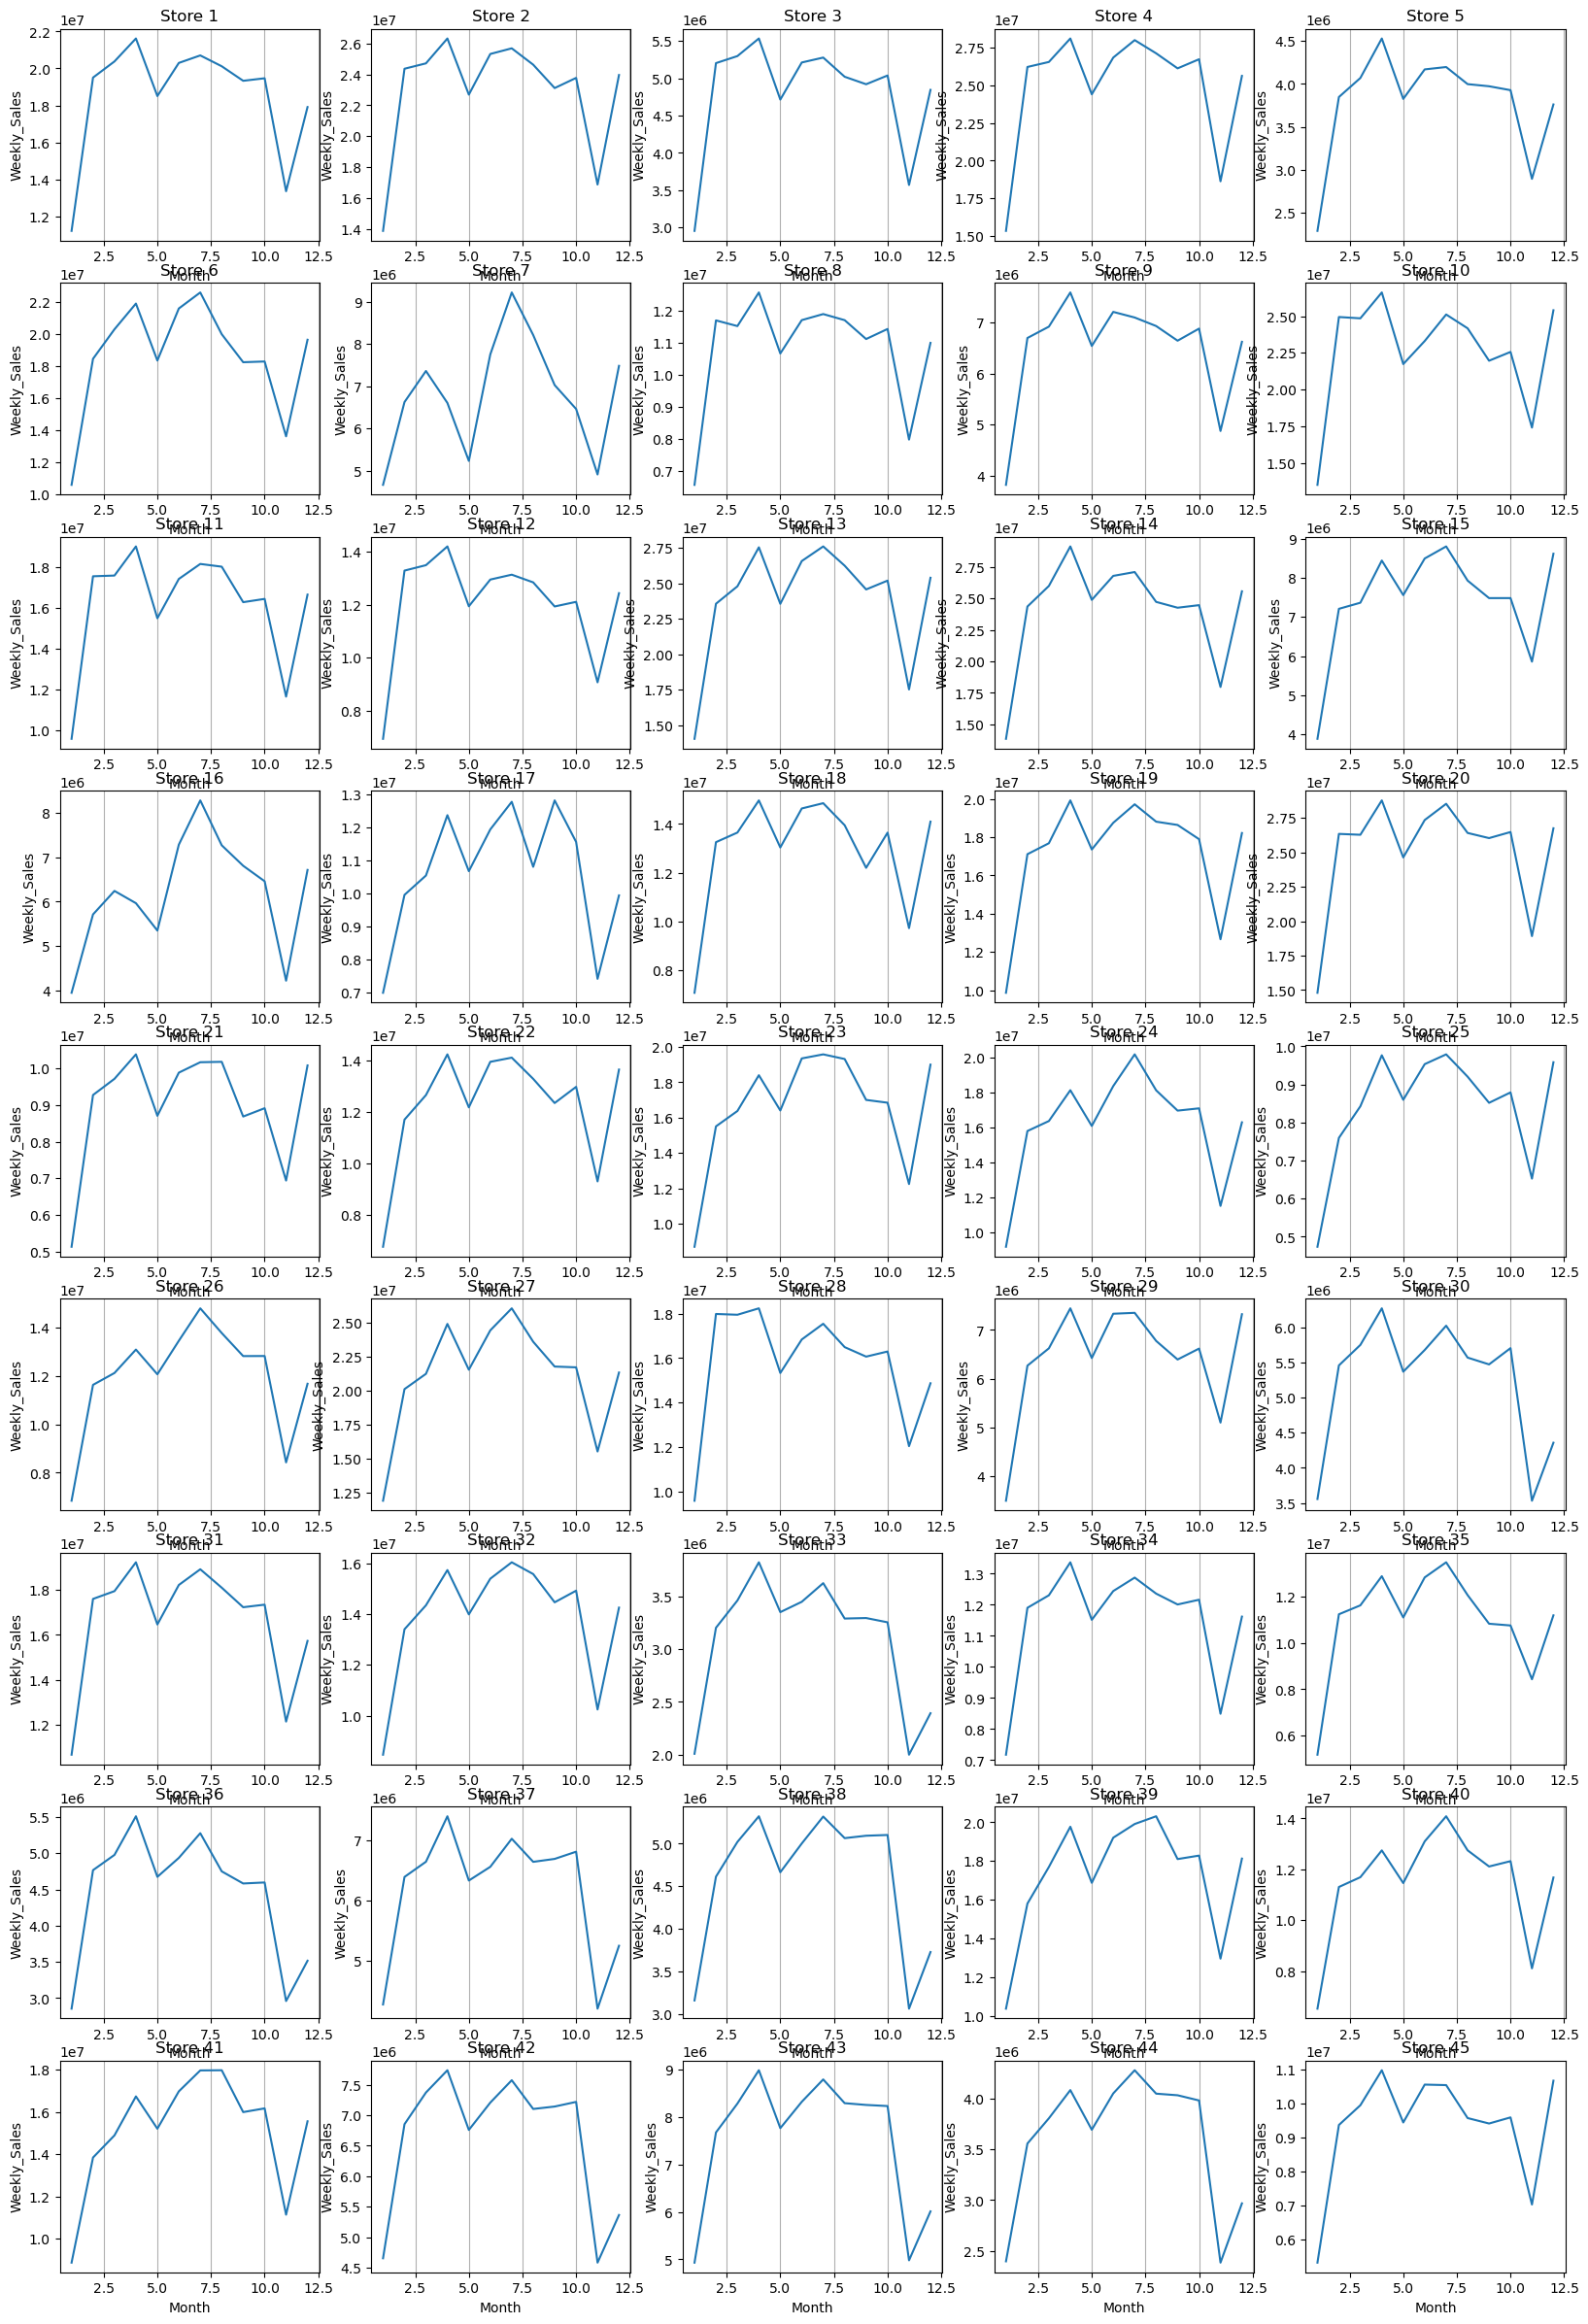

In [455]:
plt.figure(figsize=(20,30))

for i in range(1,46):
    nwide = 5
    nhigh = 0
    plt.grid(axis="x")
    #define grid
    plt.subplot(9,5,i)
    #filter data
    subset = plot.loc[plot['Store'] == str(i),:]
    #plot
    ax = sns.lineplot(data=subset,y="Weekly_Sales",x="Month")
    ax.set_title(f"Store {i}")

In [447]:
# some comments on high and low months

### 1.2.4 Exploring the data<a class="anchor" id="1.1.1"></a>
[Back to top](#table)

Explore the data provided and write code to present two plots totally worthy of presenting to the MelbourneGig company, describe your plots and discuss the findings from the plots 

sns.pairplot(df_Feature)

### 2.1.1 Discuss the feature selection and prepare the feature columns<a class="anchor" id="1.1.1"></a>
[Back to top](#table)

As we need to perform a one-step time-series prediction, meaning that the model’s prediction for the next weekly sales would be based on the previous weekly sales. The model will be used for future prediction Based on the data exploration from 1.2 and consider the situation we have, discuss which importances of those features (For example,which feature maybe useless and should be removed, which feature have a great impact to the label column,which features should be transformed) which features you are planning to use? Discuss the reasons for selecting them and how you create/transform them

Answer : Put in Documentation Part - Not here

### 2.1.2 Discuss the feature selection and prepare the feature columns<a class="anchor" id="1.1.1"></a>
[Back to top](#table)
Write code to create the columns based on your discussion above

Use case 1: We need a model to predict stores which achieve the goals, which means the weekly sales of the store divide the Store size is greater than 8.5, create a column called "achieve_goal" and use 1 to label those achieved data, 0 for others’ data

Use case 2: Join the DataFrames for our one-step time-series weekly sales prediction for stores. You should make sure the weekly sales of the previous week and Store Type as the feature of our model. For other columns, you can choose based on your answer in 2.1.1

### 2.2.1 Preparing Spark ML Transformers/Estimators for features, labels and models<a class="anchor" id="1.1.1"></a>
[Back to top](#table)
Write code to create Transformers/Estimators for transforming/assembling the columns you selected above in 2.1, and create ML model Estimators for Decision Tree and Gradient Boosted Tree model for each use case

### 2.2.2 Preparing Spark ML Transformers/Estimators for features, labels and models<a class="anchor" id="1.1.1"></a>
[Back to top](#table)
Write code to include the above Transformers/Estimators into pipelines

### 2.3.1 Preparing the training data and testing data<a class="anchor" id="1.1.1"></a>
[Back to top](#table)
Write code to split the data for training and testing purpose - use the data in 2010 and 2012 for training purpose and the half data in 2011 year for training and others as testing purpose; then cache the training and testing data

### 2.4.1 Training and evaluating models<a class="anchor" id="1.1.1"></a>
[Back to top](#table)
For use case 1, write code to use the corresponding ML Pipelines to train the models on the training data from 2.3. And then use the trained models to perform predictions on the testing data from 2.3

### 2.4.2 Training and evaluating models<a class="anchor" id="1.1.1"></a>
[Back to top](#table)
For both models’ results in use case 1, write code to display the count of each combination of above-threshold/below-threshold label and prediction label in formats like the screenshot below. Compute the AUC, accuracy, recall and precision for the above-threshold/below-threshold label from each model testing result using pyspark MLlib/ML APIs

### 2.4.2 Training and evaluating models<a class="anchor" id="1.1.1"></a>
[Back to top](#table)
Draw a ROC plot for any model you want

### 2.4.2 Training and evaluating models<a class="anchor" id="1.1.1"></a>
[Back to top](#table)
Discuss which is the better model

Discussion In the Document Part 

### 2.4.3 Training and evaluating models<a class="anchor" id="1.1.1"></a>
[Back to top](#table)
For use case 2, write code to use the corresponding ML Pipelines to train the models on the cache training data from 2.3. And then use the trained models to perform predictions on the testing data from 2.3

### 2.4.4 Evaluate regression models<a class="anchor" id="1.1.1"></a>
[Back to top](#table)
Persist the better model you selected

### 2.4.5 Evaluate regression models<a class="anchor" id="1.1.1"></a>
[Back to top](#table)
Write code to print out the features with each corresponding feature importance for the GBT model, ranked the result based on feature importance.

### 3.1 Knowledge sharing
How many jobs are observed when training the KMeans clustering model following the code below? Provide a screenshot from Spark UI for running a simple KMeans model training from the provided data

### 3.2 Explaining Kmeans
Combining the parallelism theory from lecture, Spark source code, and the Spark UI, discuss which parallelism of the kmeans algorithm in spark is more likely to belong to, data parallelism or result parallelism?
- 300 words max for the discussion
- Hint - you can also refer to the Spark source code on github https://github.com/apache/spark/blob/master/mllib/src/main/scala/org/apache/spark/mllib/clustering/KMeans.scala


Answer: In the documentation